In [1]:
import os
import torch
from omegaconf import OmegaConf
import json
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import accumulate
from run_utils import process_data, score_seqs, plot_data
from potts_mpnn_utils import PottsMPNN, parse_PDB
import etab_utils as etab_utils

In [2]:
# Define the configuration dictionary
# REPLACE paths and values with your specific requirements
config_dict = {
    "dev": "cuda" if torch.cuda.is_available() else "cpu",
    "out_dir": "outputs/example_energy_prediction",
    "out_name": "example_energy_prediction",
    "input_list": "inputs/example_list_energy_prediction.txt",  # Path to a text file containing list of PDBs
    "input_dir": "inputs/example_pdbs",  # Directory containing .pdb files
    "mutant_fasta": "inputs/example_energy_input.fasta", # Path to .fasta file with information on which mutations to predict (if None and mutant_csv is None, do DMS)
    "mutant_csv": None, #"inputs/example_energy_input.csv", # Path to .csv file with information on which mutations to predict (if None and mutant_fasta is None, do DMS)
    "model": { # Model configs (change check_path as needed, don't change others unless using a retrained model)
        "check_path": "vanilla_model_weights/pottsmpnn_20_v3.pt",
        "hidden_dim": 128,
        "edge_features": 128,
        "potts_dim": 400,
        "num_layers": 3,
        "num_edges": 48,
    },
    "inference": {
        "ddG": True, # Whether to return delta delta G (relative to wildtype) or delta G (True by default, delta G values are less interpretable)
        "mean_norm": False, # Whether to center delta delta G predictions around 0 (can sometimes help compare predictions from one protein to another)
        "max_tokens": 20000, # Max tokens to use when batching energy predictions (lower is slower but less memory intensive)
        "filter": False, # Whether to only return predictions for mutant sequences with experimental energies
        "binding_energy_json": None, # Path to json with information about how chains should be separated for binding energy calculation
        "skip_gaps": False, # Whether to skip gaps in structure (default False, but for some downstream applications like forward folding it can be convenient to set to True)
        "noise": 0.0, # Noise to add during inference (default 0.0)
        "chain_dict": None, # Dictionary with lists of designed and visible chains for each pdb (only needed if specific chains need to be designed and info is not in input_list
        "chain_ranges": None, #"inputs/example_chain_ranges.json", # Dictionary specifying ranges of positions for heatmap plotting
    }
}
config_dict["model"]["vocab"] = 22 if 'msa' in config_dict["model"]["check_path"] else 21

# Convert dictionary to an OmegaConf object for dot-notation access (cfg.model.vocab)
cfg = OmegaConf.create(config_dict)
dev = cfg.dev
print(f"Configuration loaded. Running on device: {dev}")

Configuration loaded. Running on device: cuda


In [3]:
# Load model checkpoint and construct the PottsMPNN model for inference
checkpoint = torch.load(cfg.model.check_path, map_location='cpu', weights_only=False) 
model = PottsMPNN(ca_only=False, num_letters=cfg.model.vocab, vocab=cfg.model.vocab, node_features=cfg.model.hidden_dim, edge_features=cfg.model.hidden_dim, hidden_dim=cfg.model.hidden_dim, 
                        potts_dim=cfg.model.potts_dim, num_encoder_layers=cfg.model.num_layers, num_decoder_layers=cfg.model.num_layers, k_neighbors=cfg.model.num_edges, augment_eps=cfg.inference.noise)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()
model = model.to(dev)
for param in model.parameters():
    param.requires_grad = False

# If predicting binding energies, load information about chain separation
if cfg.inference.binding_energy_json:
    with open(cfg.inference.binding_energy_json, 'r') as f:
        binding_energy_chains = json.load(f)
else:
    binding_energy_chains = None

# Setup dataset settings
pdb_list, mutant_data, chain_lens_dicts = process_data(cfg, binding_energy_chains)

In [4]:
# Iterate over PDBs, storing predictions and per-PDB statistics
scores_df = {'pdb': [], 'mutant': [], 'wildtype': [], 'ddG_pred': [], 'ddG_expt': []}
stats_df = {'pdb': [], 'Pearson r': []}
for pdb in tqdm(pdb_list):
    input_pdb = os.path.join(cfg.input_dir, pdb + '.pdb')
    chain_cuts = [0, *accumulate(list(chain_lens_dicts[pdb].values()))]

    # If calculating binding energy, determine which chain partitions need to be calculated in unbound state
    pdb_mutant_data = mutant_data[mutant_data['pdb'] == pdb]
    pdb_mutant_chains = []
    for mut_chains in pdb_mutant_data['mut_chains'].unique():
        pdb_mutant_chains += mut_chains
    pdb_mutant_chains = set(pdb_mutant_chains)
    partition_flags = []
    if binding_energy_chains:
        partition_flags = [cfg.inference.ddG and len(set(partition).intersection(pdb_mutant_chains)) > 0 for partition in binding_energy_chains[pdb]]
    
    # Parse PDB
    pdb_data = parse_PDB(input_pdb, skip_gaps=cfg.inference.skip_gaps)

    # Get sequence scores for whole complex
    scores, scored_seqs, reference_scores = score_seqs(model, cfg, pdb_data, pdb_mutant_data['ddG_expt'].values, pdb_mutant_data['sequences'].values)
    scores, scored_seqs, reference_scores = scores.squeeze(0), scored_seqs.squeeze(0), reference_scores.squeeze(0)

    # Get sequence scores for unbound state chain partitions (for binding energies only)
    p_scores = [torch.zeros_like(scores)] * len(partition_flags)
    for i_p, partition_flag in enumerate(partition_flags):
        if not partition_flag: continue
        p_scores[i_p], _, _ = score_seqs(model, cfg, pdb_data, pdb_mutant_data['ddG_expt'].values, pdb_mutant_data['partitioned_sequences'][i_p].values, binding_energy_chains[pdb][i_p])
    if len(partition_flags) > 0:
        unbound_scores = torch.cat(p_scores, dim=-1).sum(dim=-1)
        scores -= unbound_scores

    # Log info
    scores = scores.cpu().numpy()
    scored_seqs = ["".join(etab_utils.ints_to_seq_torch(seq)) for seq in scored_seqs]
    scored_seqs = [':'.join(seq[a:b] for a, b in zip(chain_cuts, chain_cuts[1:])) for seq in scored_seqs]
    reference_scores = reference_scores.cpu().numpy()
    scores_df['pdb'] += [pdb] * len(scores)
    scores_df['mutant'] += scored_seqs
    scores_df['wildtype'] += [':'.join(pdb_data[0]['seq'][a:b] for a, b in zip(chain_cuts, chain_cuts[1:]))] * len(scores)
    scores_df['ddG_pred'] += scores.tolist()
    scores_df['ddG_expt'] += reference_scores.tolist()
    stats_df['pdb'].append(pdb)
    stats_df['Pearson r'].append(np.corrcoef(scores, reference_scores)[0, 1])

# Save info
scores_df = pd.DataFrame(scores_df)
stats_df = pd.DataFrame(stats_df)
os.makedirs(cfg.out_dir, exist_ok=True)
scores_df.to_csv(os.path.join(cfg.out_dir, cfg.out_name + '_scores.csv'))
stats_df.to_csv(os.path.join(cfg.out_dir, cfg.out_name + '_stats.csv'))

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


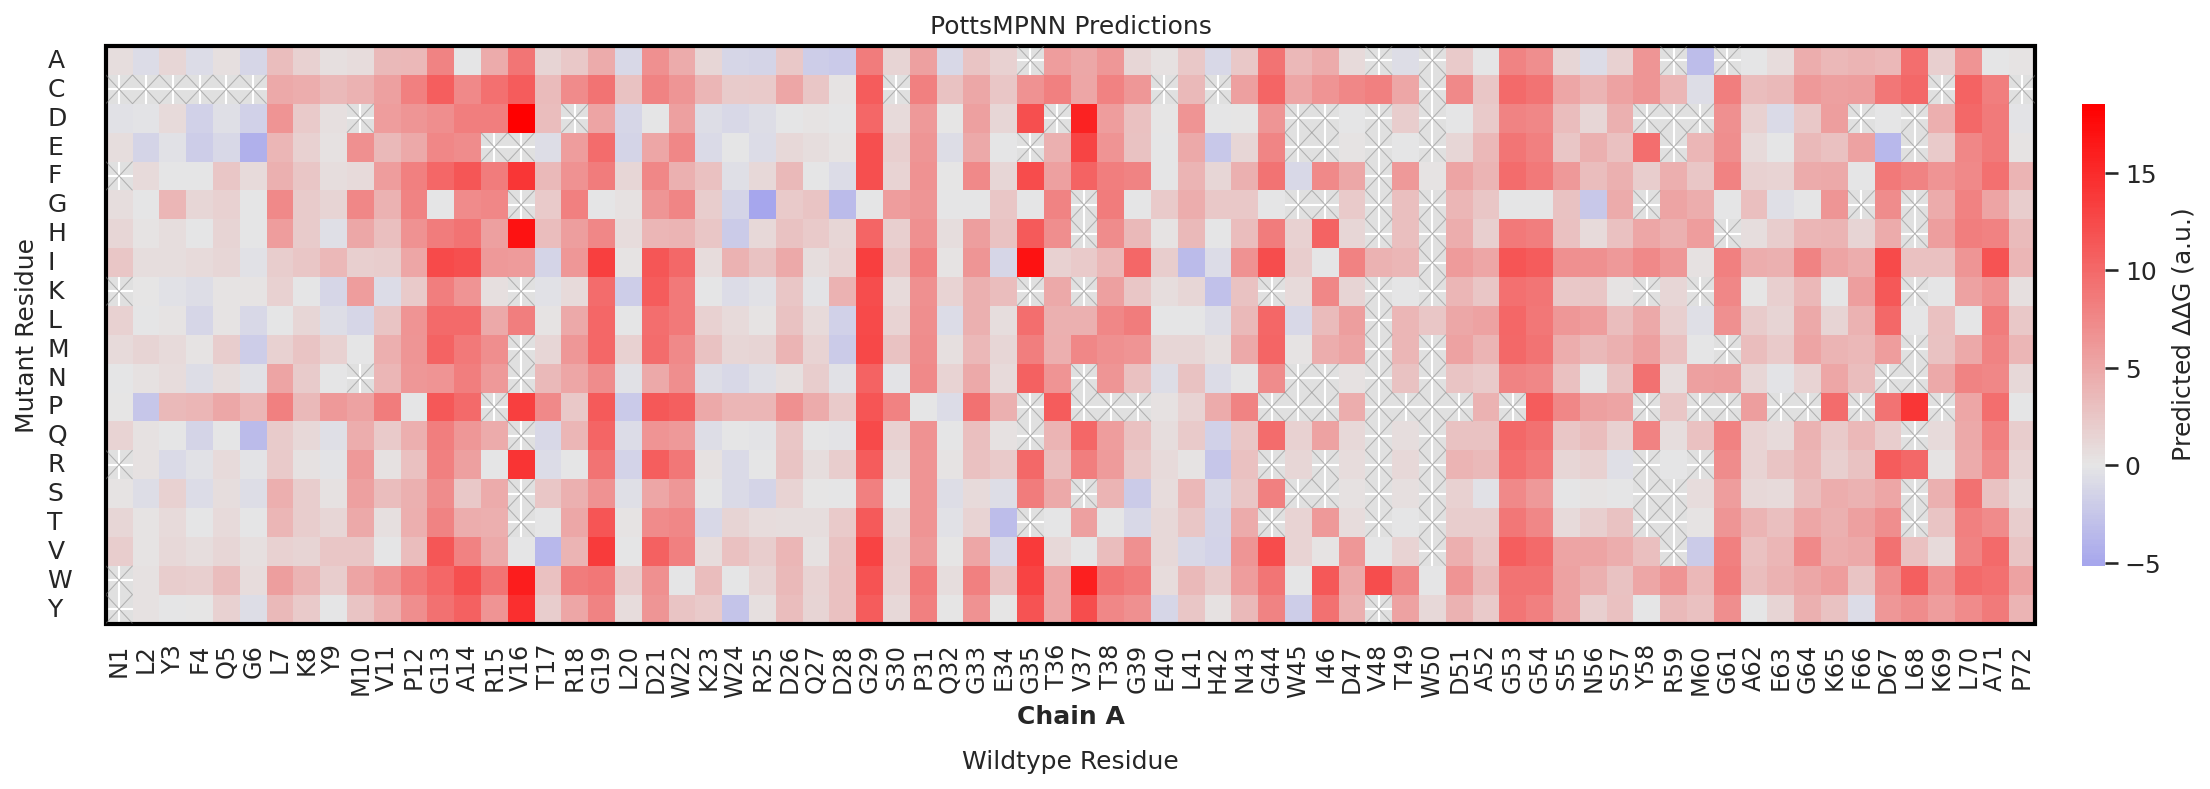

In [9]:
# Plot heatmap of results
heatmap_out_dir = os.path.join(cfg.out_dir, 'heatmaps')
os.makedirs(heatmap_out_dir, exist_ok=True)
if cfg.inference.chain_ranges:
    with open(cfg.inference.chain_ranges, 'r') as f:
        chain_ranges = json.load(f)
else:
    chain_ranges = None
for pdb in scores_df['pdb'].unique():
    pdb_scores = scores_df[scores_df['pdb'] == pdb]
    plot_data(pdb_scores,
              only_mutated_positions=False,    
              title='PottsMPNN Predictions',   
              clabel=r'Predicted $\Delta\Delta$G (a.u.)',    
              save_path=os.path.join(heatmap_out_dir, f"{pdb}.png"),
              figsize=(20, 5),
              ener_type='ddG',
              chain_order=list(chain_lens_dicts[pdb].keys()),
              chain_ranges=chain_ranges[pdb] if chain_ranges else None
             )